In [104]:
import pandas as pd
import numpy as np
import os
import json
import jsonlines
import plotly.graph_objects as go
import soccerfield
from utils import *
from voronoi_mod import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
model_1_data = pd.read_csv('model_1/model_1_data.csv')

In [106]:
def plot_vor_frame(match_id, recipient_id, receive_frame):
    file_path = f'data/FA/tracking/{match_id}.jsonl'
    with jsonlines.open(file_path, 'r') as file:
        frame_data = [line for line in file if line['frame']==receive_frame]
    file_path = f'data/FA/match/{match_id}.json'
    match_data = load_json_file(file_path) 

    pitch_length, pitch_width = match_data['pitch_length'], match_data['pitch_width']
    home_id = match_data['home_team']['id']
    away_id = match_data['away_team']['id']
    
    home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
    away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]      

    frame_df = pd.DataFrame(frame_data)
    expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
    recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()
    ball_xy = frame_data[0]['ball_data']['x'], frame_data[0]['ball_data']['y']

    defending_df = expanded_df[~expanded_df['team'].isin([recipient_team, 'ball'])]
    defending_xy = defending_df[['x', 'y']].to_numpy()

    factor_x = 1 if ball_xy[0] > 0 else -1
    factor_y = 1 if ball_xy[1] > 0 else -1
    boundary_points = np.array(
        [[ball_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-ball_xy[1])], 
         [ball_xy[0], ball_xy[1] - 40*factor_y],
         [pitch_length/2*factor_x+(pitch_length/2*factor_x-ball_xy[0]), ball_xy[1]],
         [ball_xy[0] - 40, ball_xy[1]], 
         [ball_xy[0] + 40, ball_xy[1]]])     
    points = np.vstack([ball_xy, defending_xy, boundary_points])
    points_nbs = get_neighbors(points, ball_xy)
    vertices = get_vertices(points_nbs, ball_xy)

    area_inside, area_outside, vertices_inside, vertices_outside = get_areas(vertices, ball_xy, factor_x, pitch_length)
    SoF = area_inside + np.log(area_outside+1)
    print(SoF)
    fig = plot_vor(points_nbs, ball_xy, boundary_points, vertices, vertices_inside, vertices_outside)    
    fig.show()

In [109]:
match_id = 1133201 
receive_frame = 1326.0
recipient_id = 68716
plot_vor_frame(match_id, recipient_id, receive_frame)

Exception: Number of intersections not equal to two

In [110]:
file_path = f'data/FA/tracking/{match_id}.jsonl'
with jsonlines.open(file_path, 'r') as file:
    frame_data = [line for line in file if line['frame']==receive_frame]
file_path = f'data/FA/match/{match_id}.json'
match_data = load_json_file(file_path) 

pitch_length, pitch_width = match_data['pitch_length'], match_data['pitch_width']
home_id = match_data['home_team']['id']
away_id = match_data['away_team']['id']

home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]      

frame_df = pd.DataFrame(frame_data)
expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()
ball_xy = frame_data[0]['ball_data']['x'], frame_data[0]['ball_data']['y']

defending_df = expanded_df[~expanded_df['team'].isin([recipient_team, 'ball'])]
defending_xy = defending_df[['x', 'y']].to_numpy()

factor_x = 1 if ball_xy[0] > 0 else -1
factor_y = 1 if ball_xy[1] > 0 else -1
boundary_points = np.array(
    [[ball_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-ball_xy[1])], 
     [ball_xy[0], ball_xy[1] - 40*factor_y],
     [pitch_length/2*factor_x+(pitch_length/2*factor_x-ball_xy[0]), ball_xy[1]],
     [ball_xy[0] - 40, ball_xy[1]], 
     [ball_xy[0] + 40, ball_xy[1]]])     
points = np.vstack([ball_xy, defending_xy, boundary_points])
points_nbs = get_neighbors(points, ball_xy)
vertices = get_vertices(points_nbs, ball_xy)

In [120]:
vertices

array([[ 6.06      , 19.84968765],
       [20.15441594, 20.88475682],
       [32.86652664, 34.        ],
       [ 6.06      , 34.        ]])

In [129]:
x0, y0 = ball_xy
factor_x = 1 if x0 > 0 else -1
xg, yg = pitch_length / 2 * factor_x, 0
intersections = []

# Slope of the line between (x0, y0) and (xg, yg)
slope = (yg - y0) / (xg - x0)
perp_slope = -1 / slope

def perpendicular_line(x):
    return perp_slope * (x - x0) + y0

# Find intersections with the polygon edges
for i in range(len(vertices)):
    start, end = vertices[i], vertices[(i + 1) % len(vertices)]
    print(start, end)

    # Edge: y = edge_slope * (x - x_start) + y_start
    if round(end[0], 3) == round(start[0],3):  # Vertical edge
        print('y')
        x_intersect = start[0]
        y_intersect = perpendicular_line(x_intersect)
    else:
        print('n')
        edge_slope = (end[1] - start[1]) / (end[0] - start[0])
        if perp_slope == edge_slope:  # Parallel lines
            continue
        # Solve for intersection
        x_intersect = (
            (perp_slope * x0 - edge_slope * start[0] + start[1] - y0)
            / (perp_slope - edge_slope)
        )
        y_intersect = edge_slope * (x_intersect - start[0]) + start[1]

    # Check if the intersection lies on the polygon edge
    if (
        min(start[0], end[0]) <= x_intersect <= max(start[0], end[0])
        and min(start[1], end[1]) <= y_intersect <= max(start[1], end[1])
    ):
        print(x_intersect, y_intersect)
        intersections.append([x_intersect, y_intersect])

# Ensure there are exactly two intersections
if len(intersections) != 2:
    raise Exception("Number of intersections not equal to two")

intersections = np.array(intersections)

# Divide points into closer and further groups
closer_points = []
further_points = []

# Calculate the dividing line function
for point in vertices:
    x, y = point
    # Plug point into the line 
    dx = xg - x0
    dy = yg - y0
    t = ((x - x0) * dx + (y - y0) * dy) / (dx**2 + dy**2)

    # Compute the projected point
    x_proj = x0 + t * dx
    y_proj = y0 + t * dy

    # Distance from the projection point to (xg, yg) and to (x0, y0)
    proj_to_goal = np.sqrt((x_proj - xg) ** 2 + (y_proj - yg) ** 2)
    ball_to_goal = np.sqrt((x0 - xg) ** 2 + (y0 - yg) ** 2)

    # Classify the point
    if proj_to_goal < ball_to_goal:
        closer_points.append(point)
    else:
        further_points.append(point)

[ 6.06       19.84968765] [20.15441594 20.88475682]
n
12.124310658622063 20.295039981606006
[20.15441594 20.88475682] [32.86652664 34.        ]
n
[32.86652664 34.        ] [ 6.06 34.  ]
n
28.638683812405446 34.0
[ 6.06 34.  ] [ 6.06       19.84968765]
y


In [130]:
intersections

array([[12.12431066, 20.29503998],
       [28.63868381, 34.        ]])

155.0853205335847


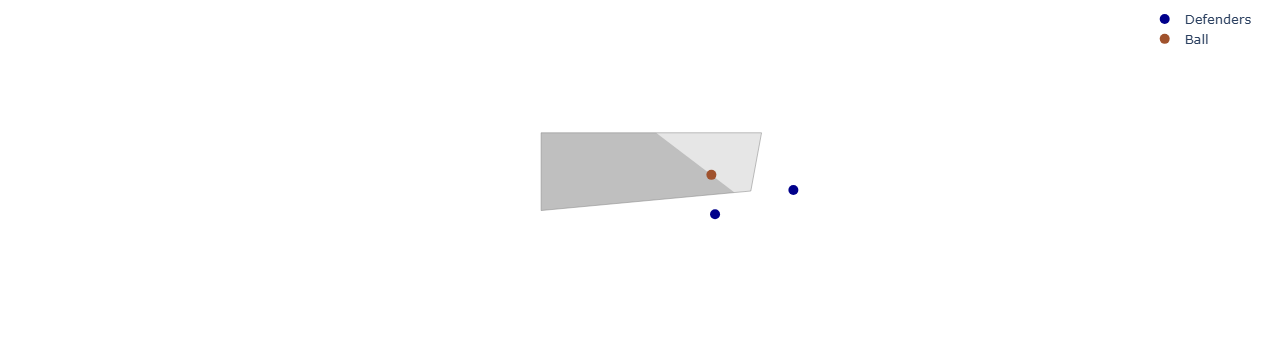

21.80048792660623


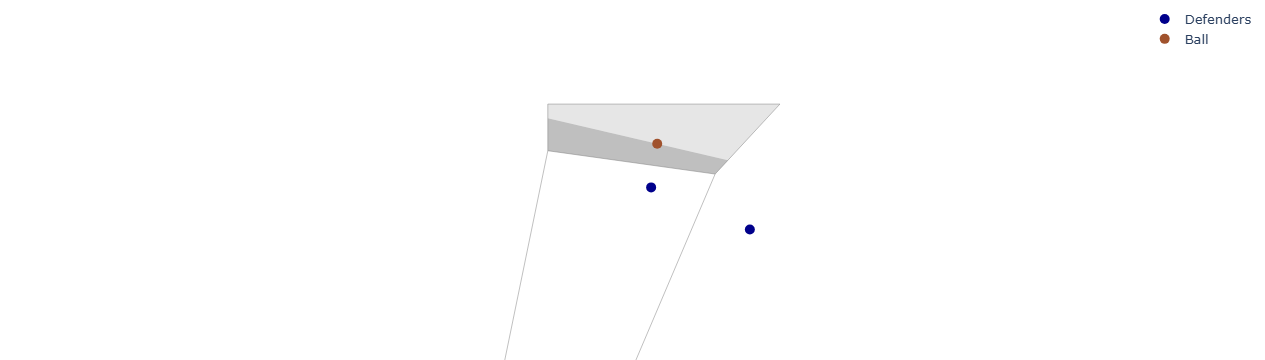

22.77981673432047


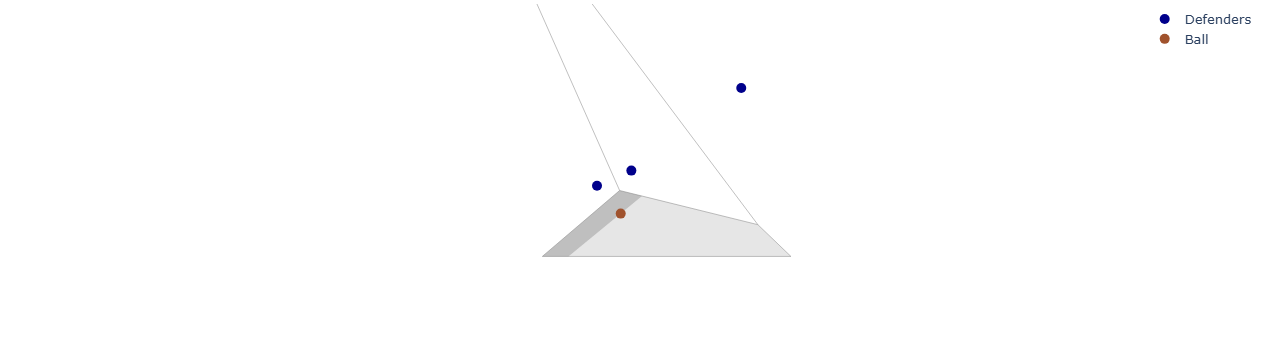

32.34117108910656


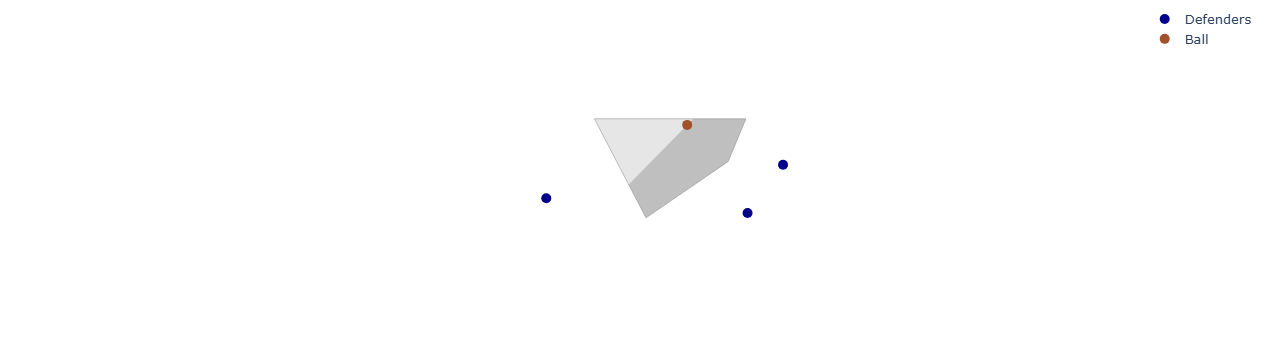

60.28597973254432


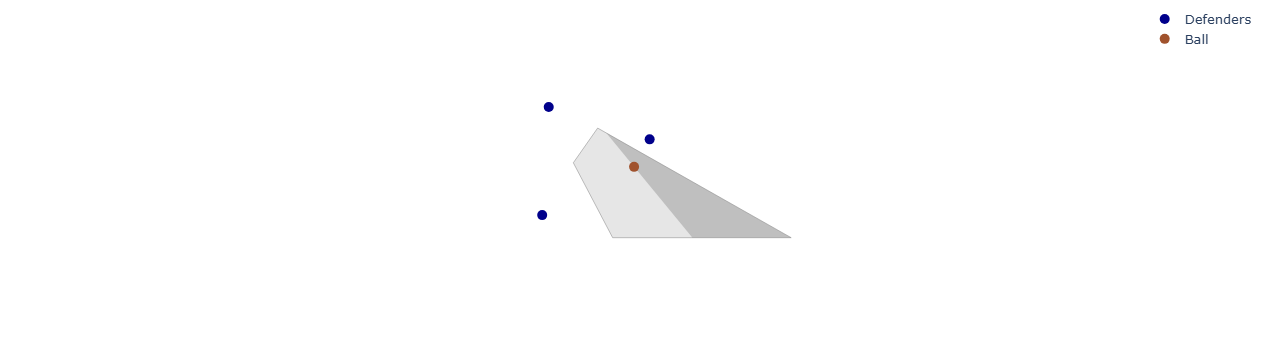

55.419736878296135


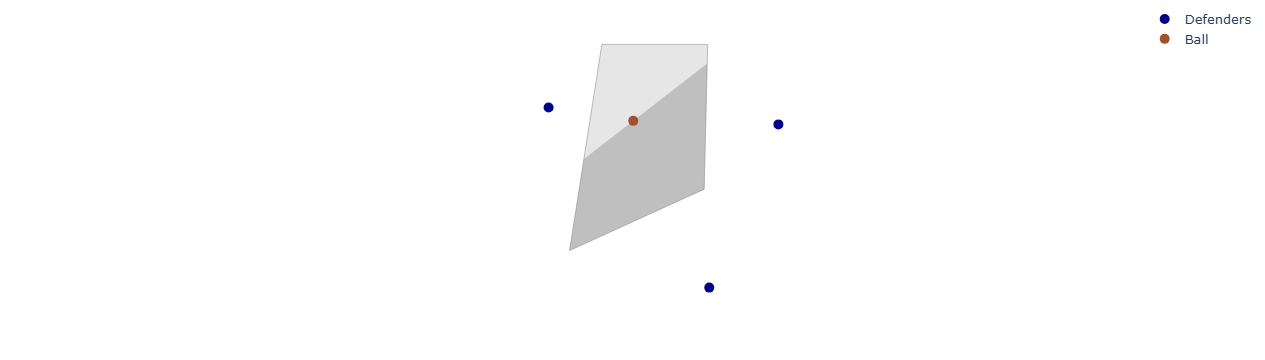

16.852256079974044


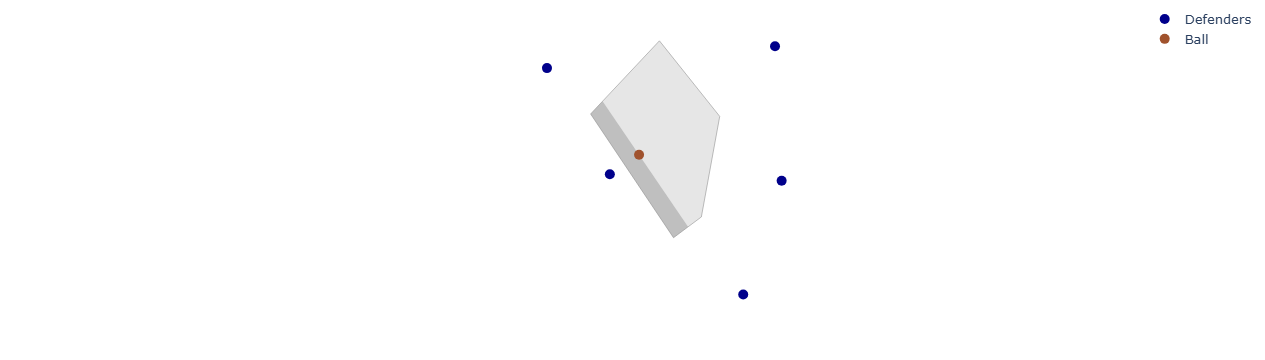

122.26548623996645


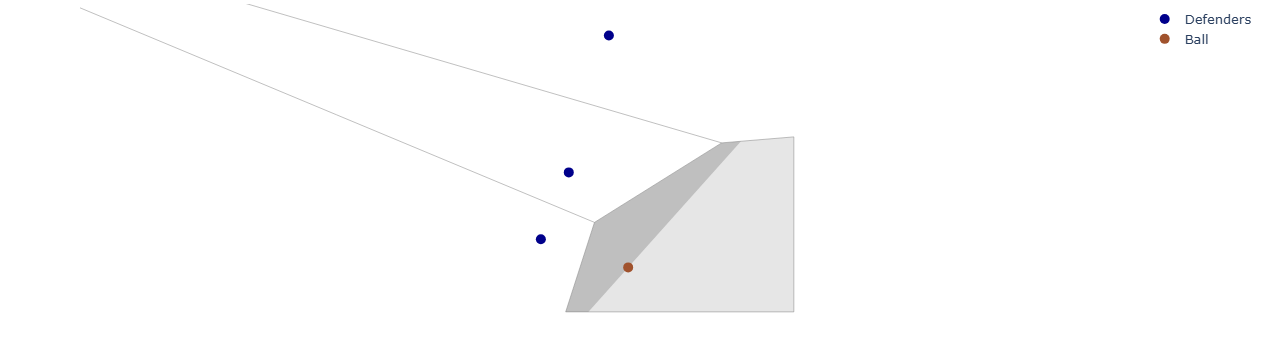

16.69733179693275


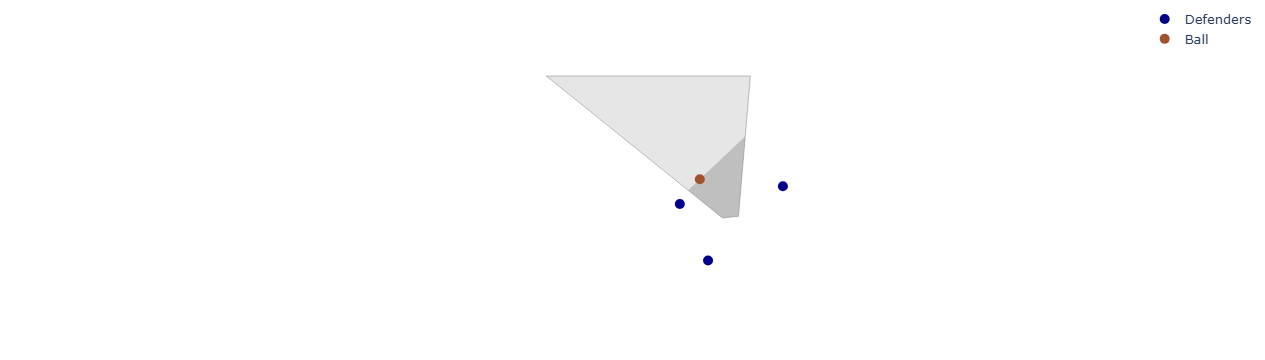

142.77392115731413


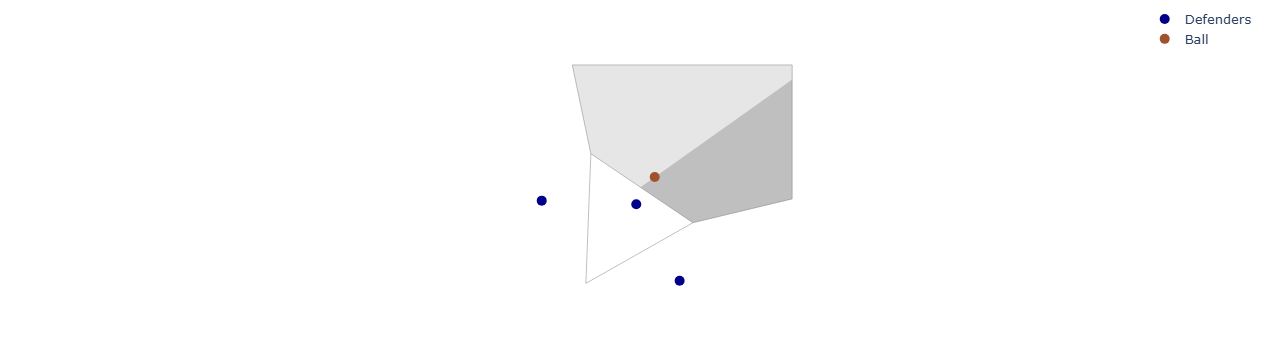

In [108]:
for idx, row in model_1_data[10:20].iterrows():
    match_id = row['sk_match_id']
    receive_frame = row['receive_frame']
    recipient_id = row['sk_recipient_id']
    plot_vor_frame(match_id, recipient_id, receive_frame)

In [17]:
SoF

259.49112108402267